## Introduction to Variational Auto Encoders (VAEs)

This notebook will introduce generative models, VAEs in particular. Earlier, we used an MLP to predict the impact location on the CDMS prototype detector based on timing measurements. However, in many applications in HEP, we need to simulate the behavior of the detector and obtain simulated dataset to be matched against the data. In this notebook, our focus is on learning the joint distribution of the timing measurements and the impact location via a NN. 

A VAE consists of two networks. The first network is called an **Encoder**, that maps the input features $(\mathbf{x})$ to a lower dimensional *latent* feature space $(\mathbf{z})$. The idea of the Encoder network is to map the unknown, perhaps complicated and untractable distribution of the input feature space to a known and tractable distribution in the latent space. Generally, the preferred choice of distribution for the latent features space is a Gaussian distribution whose mean $(\mu)$ and variances $(\sigma^2)$ are predicted by the Encoder network.

\begin{equation}
\mu, \log\sigma^2 = \mathrm{EncoderNN}_\theta(x)
\end{equation}

here $\theta$ represents the trainable parameters of the Encoder network.

**Can you think of a reason why we calculate the logarithm of the variance from the Encoder network instead of the variance directly?**

The second part of the VAE is, as you may intuitively guess, is called a **Decoder**. It is trained to predict a sample point in the input feature space from a sample in the latent space. The input dimension of the Decoder network is the same as the dimension of the latent space and the output is of the same dimension as the original input feature space.

\begin{equation}
z \sim \mathcal{N}(\mu, \sigma^2) \\
\tilde{x} = \mathrm{DecoderNN}_\phi(z)
\end{equation}

here $\phi$ represents the set of trainable parameters of the Decoder network and $\tilde{x}$ is the prediction of the Decoder network for a sample, $z$, taken from the latent space. 

To train a VAE means to have the distribution of the Decoder predicted sample, $\tilde{x}$, be as close as to the input feature distribution, $x$. Simultaneously, we want the latent space distribution to be tractable and impervious to overfitting the inherent statistical fluctuations in the input feature distributions. The first part can be accomplised by minimizing the MSE loss between $x$ and $\tilde{x}$.

\begin{equation}
\mathcal{L}_{MSE} = \frac{1}{N}\sum_{i=0}^{N-1}\left(x_i - \tilde{x}_i\right)^2
\end{equation}

For the second part, we want to make the parameterized, marginal distribution of the latent space $p_\theta(z|x)$ to be as close as possible to the prior distribution of $z$, given by $q(z) \sim \mathcal{N}(0,1)$. This is done by minimizing the so-called **KL Divergence** between these two distributions. The KL-divergence between two distributions is obtained by-

\begin{equation}
\mathrm{KL}(p_1(y)||p_2(y)) = \mathbf{E}_{p_1}\left(\log{\frac{p_1(y)}{p_2(y)}} \right)
\end{equation}

KL divergence is non-negative and is minimum when $p_1 = p2$. Also, it is not symmetric, i.e. $\mathrm{KL}(p_1(y)||p_2(y)) \neq \mathrm{KL}(p_2(y)||p_1(y))$. Going back to the loss function for VAE training- it can be written as:

\begin{align}
\mathcal{L}_{VAE} &= \mathcal{L}_{MSE} + \mathcal{L}_{DL} \\
& = \frac{1}{N}\sum_{i=0}^{N-1}\left(x_i - \tilde{x}_i\right)^2 + \mathrm{KL}(p_\theta(z|x)||q(z))
\end{align}

It can be shown that for $p_\theta(z|x) \sim \mathcal{N}(\mu, \sigma^2)$ and $q(z) \sim \mathcal{N}(0,1)$, the KL-diveregence takes the following form:


\begin{equation}
\mathrm{KL}(p_\theta(z|x)||q(z)) = -\frac{1}{2N} \sum_{i=0}^{N-1} \left[ 1 + \log\sigma_i^2 -\sigma_i^2 -\mu_i^2 \right]
\end{equation}

A full derivation of the mathematical derivation of the VAE loss function can be found [in this paper](https://doi.org/10.48550/arXiv.1907.08956).

In the following sections, we setup the code for training the VAE. Let's start by loading the necessary libraries.

In [50]:
import numpy as np
from sklearn.model_selection import *
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import pandas as pd
from matplotlib import pyplot as plt

Now we will get the data. Unlike our previous exercises, we will load the all the data features into the input vector for the Enoder network. So our input dimension for the Encoder network will be 20. We also want to make sure that the dataset has equal representation of all impact locations, so a uniform distribution can be assumed for the impact locations.

In [51]:
## Get the dataset as numpy array

data = pd.read_csv('data/CDMS_Dataset.csv', sep=',')

features = list(data.columns)[1:]
xy_data = data.values[:,1:]
n_features = len(features) - 1

unique_ys = np.unique(xy_data[:,-1])
counts = []

for y in unique_ys:
    counts.append(int(np.sum(xy_data[:,-1] == y)))

min_count = min(counts)

xy_data_uniformized = np.zeros((min_count*len(unique_ys), n_features+1))
for ii,y in enumerate(unique_ys):
    indices = xy_data[:,-1] == y
    selected = xy_data[indices][:min_count, :]
    xy_data_uniformized[ii*min_count:(ii+1)*min_count, :] = selected

print(xy_data_uniformized)
xy_data = xy_data_uniformized
y_norm = -41.9 # largest y dimension to be used to normalize y data
x_mean = np.mean(xy_data[:,:-1], axis = 0)
x_std  = np.std(xy_data[:,:-1], axis = 0)


def split_data(split_type='random', labels = []):
    if split_type == 'random':
        XY_train, XY_test  = train_test_split(xy_data, test_size=0.25, stratify=xy_data[:, -1])
    if split_type == 'label':
        XY_train = data.loc[~data[features[-1]].isin(labels)].values[:, 1:]
        XY_test = data.loc[data[features[-1]].isin(labels)].values[:, 1:]
    XY_train[:,:-1] = (XY_train[:,:-1] - x_mean)/x_std
    XY_test[:,:-1]  = (XY_test[:,:-1] - x_mean)/x_std
    XY_train[:,-1]  = 1*(2*XY_train[:,-1]/y_norm - 1)
    XY_test[:,-1]   = 1*(2*XY_test[:,-1]/y_norm -1)
    
    return XY_train, XY_test

[[-7.140e-06  5.546e-05  4.091e-07 ...  1.590e-04  2.262e-04 -4.190e+01]
 [-6.190e-06  5.518e-05  1.451e-06 ...  1.420e-04  2.253e-04 -4.190e+01]
 [-4.630e-06  5.614e-05  4.625e-06 ...  1.250e-04  2.216e-04 -4.190e+01]
 ...
 [-2.500e-06 -1.680e-05 -1.530e-05 ...  1.862e-04  8.695e-05  0.000e+00]
 [-5.140e-06 -1.680e-05 -1.120e-05 ...  5.403e-05  4.833e-05  0.000e+00]
 [-5.850e-06 -1.550e-05 -1.160e-05 ...  1.466e-04  4.031e-05  0.000e+00]]


In [52]:
## Defining a class for a generic MLP

class Network(nn.Module):
    def __init__(self, Layers, device, activation, 
                 end_in_sigmoid = False, 
                 add_dropout = False, 
                 add_batchnorm = False):
        super(Network, self).__init__()
        self.Layers = Layers
        self.device = device
        self.activation = activation
        self.end_in_sigmoid = end_in_sigmoid
        self.add_dropout = add_dropout,
        self.add_batchnorm = add_batchnorm,
        self.NN = self.build_model().to(device)
        
    def build_model(self):
        Seq = nn.Sequential()
        for ii in range(len(self.Layers)-1):
            this_module = nn.Linear(self.Layers[ii], self.Layers[ii+1])
            Seq.add_module("Linear" + str(ii), this_module)
            if not (ii == len(self.Layers)-2):
                if self.add_batchnorm[0]:
                    Seq.add_module("BatchNorm" + str(ii), nn.BatchNorm1d(self.Layers[ii+1]))
                Seq.add_module("Activation" + str(ii), self.activation)
                if self.add_dropout[0]:
                    Seq.add_module("Dropout" +str(ii), nn.Dropout(p=0.5, inplace=False))
            if self.end_in_sigmoid:
                Seq.add_module("Sigmoid" + str(ii), nn.Sigmoid())
        return Seq
    
    def forward(self, X):
        X = X.to(self.device)
        return self.NN(X)

In [53]:
class CDMS_NNSuite:
    def __init__(self, XY_train, XY_test, device):
        self.XY_train = torch.tensor(XY_train, dtype = torch.float32, device = device)
        self.XY_test  = torch.tensor(XY_test,  dtype = torch.float32, device = device)
        self.device = device

    
class CDMS_VAE(CDMS_NNSuite):
    def __init__(self, XY_train, XY_test, 
                 enc_Layers, dec_Layers,
                 device, activation=nn.Sigmoid()):
        super().__init__(XY_train, XY_test, device)
        self.enc_Layers = enc_Layers
        self.dec_Layers = dec_Layers
        self.Encoder = Network(enc_Layers, device, activation,
                              end_in_sigmoid = False, 
                              add_dropout = False, 
                              add_batchnorm = False)
        self.Decoder = Network(dec_Layers, device, activation)
        
    
    def Evaluator(self, xy, lossfn):
        enc_output = self.Encoder.forward(xy).to(self.device)
        mu, logvar = enc_output[:, :int(self.enc_Layers[-1]/2)], enc_output[:, int(self.enc_Layers[-1]/2):]
        #print(mu.shape, logvar.shape)
        z = mu + torch.exp(logvar/2)*torch.randn_like(mu) # reparameterization
        z = z.reshape((-1, int(self.enc_Layers[-1]/2)))
        #print(z.shape)
        dec_output = self.Decoder(z).to(self.device)
                
        mse_loss = torch.sum((dec_output.reshape(-1) - xy.reshape(-1))**2)/xy.shape[0]
        KL_div = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar))/xy.shape[0]
        
        return mu, logvar, z, dec_output, mse_loss, KL_div
    
    
    def Train(self, n_epochs, batch_size, lossfn=nn.MSELoss(reduction='mean')):
        Train_MSE_Losses = []
        Train_KL_Losses = []
        Test_MSE_Losses = []
        Test_KL_Losses = []
        params = list(self.Encoder.NN.parameters()) + list(self.Decoder.NN.parameters())
        optimizer = optim.Adam(params, lr=1e-3)
        for ii in range(n_epochs):
            self.Encoder.train()
            self.Decoder.train()
            DL = DataLoader(self.XY_train, batch_size=batch_size, shuffle=True, drop_last=True)
            for xy in DL:
                mu, logvar, z, dec_output, mse_loss, KL_div = self.Evaluator(xy, lossfn)
                optimizer.zero_grad()
                total_loss = mse_loss + KL_div
                
                total_loss.backward()
                optimizer.step()
                
            self.Encoder.eval()    
            self.Decoder.eval()
            with torch.no_grad():
                mu, logvar, z, dec_output, mse_loss, KL_div = self.Evaluator(self.XY_train, lossfn)
                Train_MSE_Losses.append(mse_loss.item())
                Train_KL_Losses.append(KL_div.item())
                
                mu, logvar, z, dec_output, mse_loss, KL_div = self.Evaluator(self.XY_test, lossfn)
                Test_MSE_Losses.append(mse_loss.item())
                Test_KL_Losses.append(KL_div.item())
                
                if ii % int(n_epochs/10) == 0 or ii == n_epochs - 1:
                    print('''Epoch {0}/{1}, 
                        Training MSE Loss = {2:0.4f} 
                        Training KL Div   = {3:0.4f}
                        Test MSE Loss     = {4:0.4f}
                        Test KL div       = {5:0.4f}
                        '''.format(ii, n_epochs, 
                                   Train_MSE_Losses[-1], Train_KL_Losses[-1],
                                   Test_MSE_Losses[-1],  Test_KL_Losses[-1]
                                  )
                         )
            
        
        return Train_MSE_Losses, Train_KL_Losses, Test_MSE_Losses, Test_KL_Losses

In [54]:
NLatent = 3
NNodes = 32
NhiddenLayers = 2
enc_Layers =  [n_features+1] + NhiddenLayers*[NNodes] + [2*NLatent]
dec_Layers =  [NLatent]  + NhiddenLayers*[NNodes] + [n_features+1]
# gen_Layers = [3, 32, 32, 20]
# disc_Layers = [20, 128, 64, 1]
XY_train, XY_test = split_data('random')
lossfn = nn.MSELoss(reduction='mean')
device = torch.device('cpu')
#activation = nn.LeakyReLU(negative_slope=0.01)
activation = nn.Sigmoid()
n_epochs = 2000
batch_size = 128


NNvae =  CDMS_VAE(XY_train = XY_train, 
                  XY_test = XY_test, 
                  enc_Layers = enc_Layers, 
                  dec_Layers = dec_Layers,
                  device = device, 
                  activation = activation)

Train_MSE_Losses, Train_KL_Losses, Test_MSE_Losses, Test_KL_Losses = NNvae.Train(n_epochs = n_epochs,
                                                                                 batch_size = batch_size,
                                                                                 lossfn = lossfn)


Epoch 0/2000, 
                        Training MSE Loss = 19.2064 
                        Training KL Div   = 0.0046
                        Test MSE Loss     = 20.1146
                        Test KL div       = 0.0046
                        
Epoch 200/2000, 
                        Training MSE Loss = 3.2279 
                        Training KL Div   = 2.6137
                        Test MSE Loss     = 4.0307
                        Test KL div       = 2.6093
                        
Epoch 400/2000, 
                        Training MSE Loss = 3.0299 
                        Training KL Div   = 2.5956
                        Test MSE Loss     = 3.6100
                        Test KL div       = 2.5900
                        
Epoch 600/2000, 
                        Training MSE Loss = 2.9353 
                        Training KL Div   = 2.6042
                        Test MSE Loss     = 3.5315
                        Test KL div       = 2.6028
                        
Epoch 800/20

In [55]:
mu, logvar, z, dec_output, mse_loss, KL_div = NNvae.Evaluator(NNvae.XY_train, lossfn)
mu2, logvar2, z2, dec_output2, mse_loss2, KL_div2 = NNvae.Evaluator(NNvae.XY_test, lossfn)

In [56]:
torch.sum((NNvae.XY_train - dec_output)**2)/NNvae.XY_train.shape[0]

tensor(2.4361, grad_fn=<DivBackward0>)

In [57]:
dec_output[0:2,:]

tensor([[-8.9038e-02,  1.2406e+00,  1.8673e+00,  1.5845e+00, -1.1911e+00,
         -9.9607e-01,  3.3330e-02,  5.1177e-01,  1.2594e+00, -7.0460e-01,
         -1.4495e-01,  9.9634e-02, -1.3437e-03,  2.5501e-01, -1.4439e+00,
         -1.4496e+00, -1.3667e-01,  1.0409e-01,  5.9766e-01,  9.6758e-01],
        [-3.2162e-01, -1.7683e+00,  1.1141e-01, -1.0495e+00,  1.4456e+00,
          9.2688e-01, -2.0527e+00, -3.0308e-01, -1.1778e+00, -9.2142e-01,
         -1.3540e+00, -1.2998e+00, -1.3828e+00, -1.8681e+00,  7.6852e-01,
         -1.8321e-01, -1.6878e+00, -2.3723e-01, -1.9044e+00, -9.9022e-01]],
       grad_fn=<SliceBackward0>)

Now let's explore the behavior of the model. First, we want to see how well the model behaves in reproducing the impact location from the decoder.

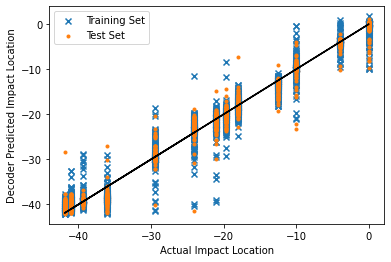

In [58]:
f1_org = NNvae.XY_train[:,-1].numpy()
f1_pred = dec_output[:,-1].detach().numpy()
f1_org2 = NNvae.XY_test[:,-1].numpy()
f1_pred2 = dec_output2[:,-1].detach().numpy()

f1_org = (f1_org + 1)*y_norm/2
f1_pred = (f1_pred + 1)*y_norm/2
f1_org2 = (f1_org2 + 1)*y_norm/2
f1_pred2 = (f1_pred2 + 1)*y_norm/2
plt.scatter(f1_org, f1_pred, marker='x', label='Training Set')
plt.scatter(f1_org2, f1_pred2, marker='.', label='Test Set')
plt.plot(f1_org, f1_org, color='k')
plt.xlabel('Actual Impact Location')
plt.ylabel('Decoder Predicted Impact Location')
plt.legend()

We can see that the model is somewhat poorly replicating the impact location at the extreme points while the performance is more reasonable for the intermediate locations. We can more closely inspect the distribution of the predicted impact locations from the decoder. Remember, in the normalized dataset, the location $y = -41.9$ represents at normalized value of 1 while $y = 0$ represents a normalized value of -1

In [59]:
XY = NNvae.XY_train

indices = XY[:,-1]==-1
data0 = XY[indices]
indices = XY[:,-1]==1
data1 = XY[indices]

f10 = data0[:,1].numpy()
f11 = data1[:,1].numpy()

(array([ 2.,  2.,  7., 20., 36., 68., 76., 36., 15.,  5.]),
 array([-1.990422 , -1.9496757, -1.9089292, -1.8681829, -1.8274364,
        -1.7866901, -1.7459438, -1.7051973, -1.664451 , -1.6237046,
        -1.5829582], dtype=float32),
 <BarContainer object of 10 artists>)

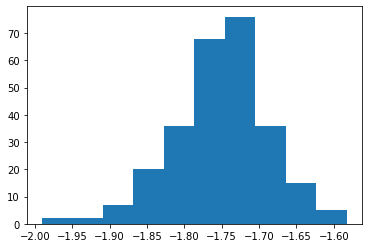

In [60]:
plt.hist(f10) # The distribution for y = -1

(array([ 6.,  3.,  3., 25., 53., 72., 57., 35.,  9.,  5.]),
 array([0.9323153, 0.9786032, 1.024891 , 1.0711789, 1.1174668, 1.1637547,
        1.2100426, 1.2563304, 1.3026183, 1.3489062, 1.395194 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

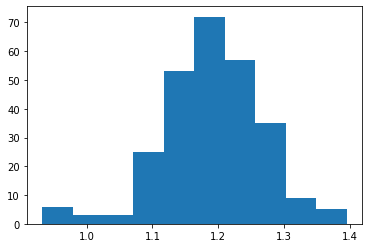

In [61]:
plt.hist(f11) # The distribution for y = 1

Next, let's try to look at the latent space. The latent space is expected to learn about the distribution of the input features. Hence, it can show strong correlation with the input features. Let's see how those distributions look like for the different impact locations.

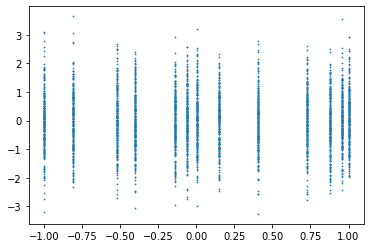

In [62]:
y = XY[:,-1].numpy()
z0 = z[:,0].detach().flatten().numpy()
z1 = z[:,1].detach().flatten().numpy()
z2 = z[:,2].detach().flatten().numpy()
plt.scatter(y,z0,label='z0',marker='.', s=2)

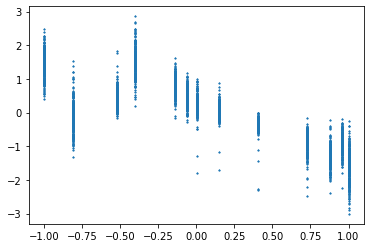

In [63]:
plt.scatter(y,z1,label='z1',marker='*',s=2)

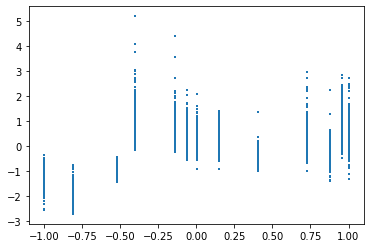

In [64]:
plt.scatter(y,z2,label='z2',marker='+', s=2)

As you can see, some of these latent spaces actually show a strong correlation with impact location while others are rather randomly distributed, showing almost no correlation. These patterns will vary every time you run the code and retrain the model, since there is no *a priori* way of telling how these correlations will build up during model training.

You may have noted that the model's performance is not so great. Can you think of ways to improve it? Try changing the hyperparameters (number of layers, number of nodes per layer, number of epochs etc.) Also, there are modified architectures for VAE, like the so-called $\beta$-VAE [(link to paper)](https://openreview.net/forum?id=Sy2fzU9gl). The $\beta$-VAE architecture is expected to disentangle the dimensions of the latent space representation. Hence, it may allow a single latent space dimension to more strongly correlate with the impact location compared what you are seeing with the plain VAE architecture